# 3D forward simulation of ZTEM data

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

import discretize
from pymatsolver import Pardiso as Solver
from SimPEG import maps, data
# from SimPEG import maps, utils, data, optimization, maps, objective_function, regularization, inverse_problem, directives, inversion, data_misfit
from SimPEG.electromagnetics import natural_source as nsem
from SimPEG.utils import plot2Ddata, surface2ind_topo

## create a tensor mesh

In [2]:
# core mesh 
csx = 100  # cell size in the x, y directions
ncx = 13   # number of cells in the x, y directions
csz = 25   # number of cells in the z direction
ncz = int(350/csz)  # number of cells in the z direction 
nca = 3  # number of core cells above z=0 (for modelling topography) 

npad = 5   # number of padding cells in x, y
npadz = 8  # number of padding cells in z

# create the tensor mesh
mesh = discretize.TensorMesh(
    [
        [(csx, npad, -1.5), (csx, ncx), (csx, npad, 1.5)],
        [(csx, npad, -1.5), (csx, ncx), (csx, npad, 1.5)],
        [(csz, npadz, -1.6), (csz, ncz+nca), (csz, npadz, 1.6)],
    ], origin="CC0"
)
mesh.origin = mesh.origin + np.r_[0, 0, -mesh.h[2][:npadz+ncz].sum()]

mesh

TensorMesh: 17,457 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     23     -2,628.12      2,628.12    100.00    759.38    1.50
   y     23     -2,628.12      2,628.12    100.00    759.38    1.50
   z     33     -3,146.64      2,871.64     25.00  1,073.74    1.60

In [3]:
# Setup the model

sig_back = 1e-2
sig_block = 1
sig_air = 1e-8

frequencies = np.r_[30, 45, 90, 180, 360, 720]

print("skin depths")
print(503/np.sqrt(sig_back * frequencies))

skin depths
[918.34815475 749.82812845 530.20855435 374.91406423 265.10427718
 187.45703211]


In [4]:
def topography(x, y, length_scale=500, height=150): 
    return -height*np.sin(x/length_scale) * np.exp(-(x/length_scale)**2) * np.exp(-(y/length_scale)**2)

In [5]:
models = {}

block_x = np.r_[-150, 150]
block_y = np.r_[-150, 150]
block_z = np.r_[-200, -350]

block_inds = (
    (mesh.cell_centers[:, 0] <= block_x.max()) & (mesh.cell_centers[:, 0] >= block_x.min()) &
    (mesh.cell_centers[:, 1] <= block_y.max()) & (mesh.cell_centers[:, 1] >= block_y.min()) &
    (mesh.cell_centers[:, 2] <= block_z.max()) & (mesh.cell_centers[:, 2] >= block_z.min()) 
)
    
halfspace = sig_air * np.ones(mesh.n_cells)
halfspace[mesh.cell_centers[:, 2] < 0] = sig_back
models["halfspace"] = halfspace

block_in_halfspace = halfspace.copy()
block_in_halfspace[block_inds] = sig_block
models["block"] = block_in_halfspace

topo_model = sig_air * np.ones(mesh.n_cells)
topo = topography(mesh.cell_centers[:, 0], mesh.cell_centers[:,1])
topo_model[mesh.cell_centers[:, 2] <= topo] = sig_back
models["topo"] = topo_model

topo_block = topo_model.copy()
topo_block[block_inds] = sig_block
models["topo_block"] = topo_block

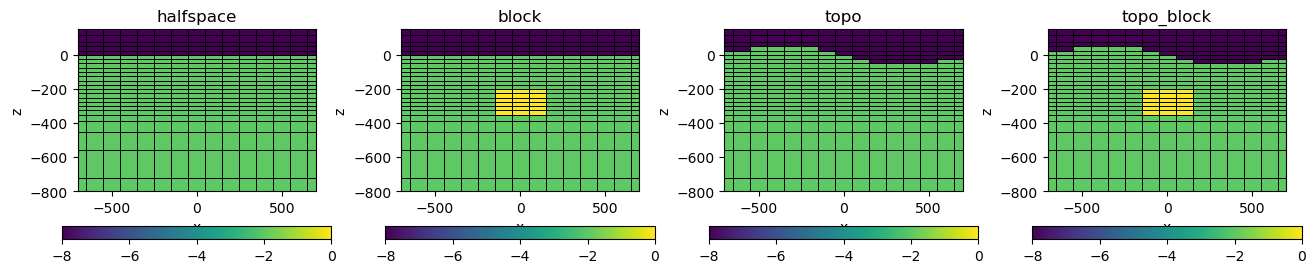

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(16, 3))

xlim = 700*np.r_[-1, 1]
ylim = np.r_[-800, 150]

for i, key in enumerate(models.keys()):
    out = mesh.plot_slice(
        np.log10(models[key]), grid=True, normal="Y", ax=ax[i], 
        pcolor_opts={"vmin":np.log10(sig_air), "vmax":np.log10(sig_block)},
        grid_opts={"color":"k", "lw":0.5},
    )
    cb = plt.colorbar(out[0], orientation="horizontal")
    ax[i].set_title(key)

    ax[i].set_xlim(xlim)
    ax[i].set_ylim(ylim)
    ax[i].set_aspect(1)

# ax.plot(mesh.cell_centers_x, topography(mesh.cell_centers_x, np.zeros_like(mesh.cell_centers_x)))

## create the SimPEG survey

In [7]:
# Setup the the survey object
# Receiver locations
rx_x = np.arange(-600, 601, 100)
rx_z = 90
rx_loc = np.vstack([discretize.utils.mkvc(x) for x in np.meshgrid(rx_x, np.r_[0], np.r_[rx_z])]).T

# Make a receiver list
rx_list = []
for rx_orientation in ["zx", "zy"]:

    # specify that we are using tipper data 
    rx_real = nsem.Rx.Point3DTipper(rx_loc, rx_orientation, "real")
    rx_imag = nsem.Rx.Point3DTipper(rx_loc, rx_orientation, "imag")

    # append to the receiver list
    rx_list.append(rx_real)
    rx_list.append(rx_imag)

# Source list
source_list = [
    nsem.sources.PlanewaveXYPrimary(rx_list, freq, sigma_primary=halfspace) for freq in frequencies
    # Planewave_xy_1Dprimary(rx_list, freq, sigma_primary=halfspace) for freq in frequencies
]
# Survey MT
survey = nsem.Survey(source_list)

# Setup the problem object
sim = nsem.Simulation3DPrimarySecondary(
    mesh, survey=survey, solver=Solver, sigmaMap=maps.IdentityMap(mesh), sigmaPrimary=halfspace
)



### plot topography and survey line

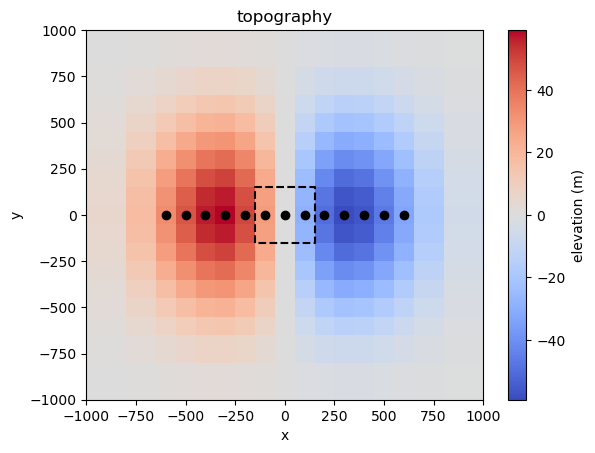

In [8]:
fig, ax = plt.subplots(1, 1)
out = mesh.plot_slice(topo, "CC", pcolor_opts={"cmap":"coolwarm"}, ax=ax)

lims = 1000
ax.set_xlim(lims*np.r_[-1, 1])
ax.set_ylim(lims*np.r_[-1, 1])
ax.plot(rx_x, np.zeros_like(rx_x), "ko")

ax.plot(
    np.r_[block_x.min(), block_x.min(), block_x.max(), block_x.max(), block_x.min()],
    np.r_[block_y.min(), block_y.max(), block_y.max(), block_y.min(), block_y.min()],
    "--k"
)
ax.set_title("topography")
cb=plt.colorbar(out[0], ax=ax)
cb.set_label("elevation (m)")

## run the forward simulation 

In [9]:
fields = {}
dobs = {}

In [10]:
for key, sig in models.items():
    if key not in fields.keys(): 
        print(f"starting {key}")
        t = time.time()
        fields[key] = sim.fields(sig)
        dobs[key] = sim.dpred(sig, f=fields[key])
        print(f"done {key}... elapsed time: {time.time()-t:1.1e}s \n")

starting halfspace
done halfspace... elapsed time: 2.5e+01s 

starting block
done block... elapsed time: 2.4e+01s 

starting topo
done topo... elapsed time: 2.3e+01s 

starting topo_block
done topo_block... elapsed time: 2.2e+01s 



### put data into a data object

In [11]:
data_dict = {}
for key, d in dobs.items():
    data_dict[key] = data.Data(dobs=d, survey=survey)

## Plot the results 

You can change the `key` to view different results

Text(0.5, 0, 'x (m)')

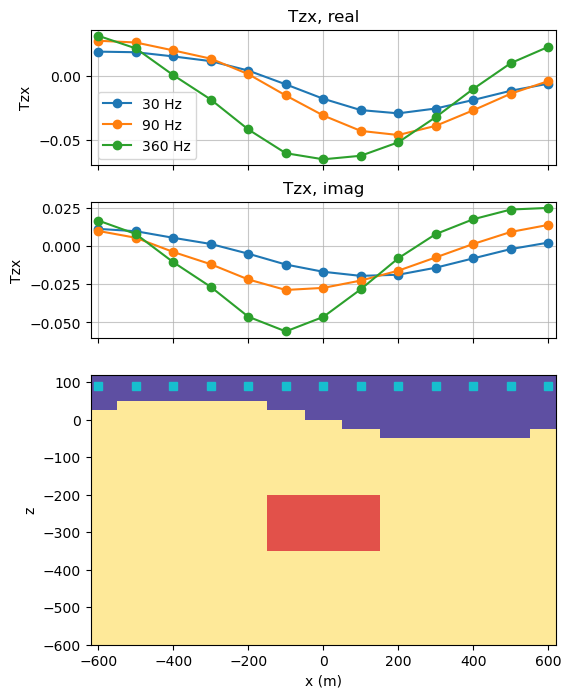

In [12]:
fig, ax = plt.subplots(3, 1, height_ratios=[1, 1, 2], figsize=(6, 8))

xlim = 620*np.r_[-1, 1]
ylim= np.r_[-600, 120]
key = "topo_block"
src_ind = 4

plotme = "model"

for j, src in enumerate(source_list[::2]):
    for i, rx in enumerate(rx_list[:2]):
        ax[i].plot(rx_x, data_dict[key][src, rx], "-o", color=f"C{j}", label=f"{src.frequency:1.0f} Hz")
        ax[i].set_title(f"T{rx.orientation}, {rx.component}")
        ax[i].set_ylabel(f"T{rx.orientation}")

for a in ax[:2]:
    a.grid("both", alpha=0.7)  
    a.set_xticklabels("")
    a.set_xlim(xlim)
ax[0].legend()

if plotme=="model":
    out = mesh.plot_slice(models[key], normal="Y", ax=ax[2], pcolor_opts={"norm":LogNorm(vmin=1e-6, vmax=10), "cmap":"Spectral_r"})
elif plotme=="b":
    out = mesh.plot_slice(
        fields[key][srcList[src_ind], plotme][:, 0].real, "F", view="vec", normal="Y", ax=ax[2],
        range_x=xlim, range_y=ylim
    )
elif plotme=="j":
    out = mesh.plot_slice(
        fields[key][srcList[src_ind], plotme][:, 0].imag, "E", view="vec", normal="Y", ax=ax[2],
        range_x=xlim, range_y=ylim
    )
    # cb = plt.colorbar(out[0], shrink=0.4)
# cb.set_label("conductivity (S/m)")


ax[2].set_xlim(xlim)
ax[2].set_ylim(ylim)
ax[2].set_aspect(1)
ax[2].set_title("")
ax[2].plot(rx_x, np.ones_like(rx_x)*rx_z, "C9s")

ax[2].set_xlabel("x (m)")


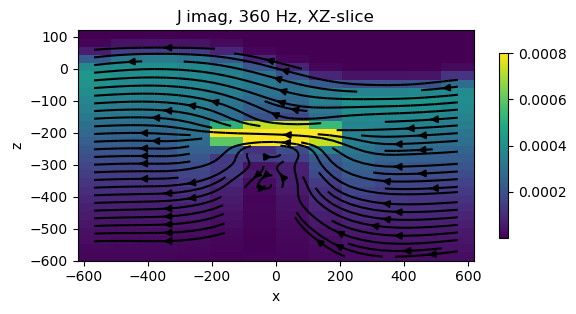

In [13]:
fig, ax = plt.subplots(1, 1) 

key = "topo_block"
src_ind = 4

out = mesh.plot_slice(
    fields[key][source_list[src_ind], "j"][:, 0].imag, "E", view="vec", normal="Y", ax=ax,
    range_x=xlim, range_y=ylim, pcolor_opts={"norm": Normalize(vmax=8e-4)},
    stream_threshold=1e-5
)
plt.colorbar(out[0], ax=ax, shrink=0.5)
ax.set_title(f"J imag, {frequencies[src_ind]} Hz, XZ-slice")
ax.set_aspect(1)

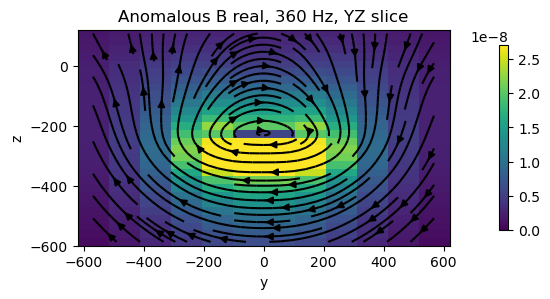

In [14]:
fig, ax = plt.subplots(1, 1) 

key = "topo_block"
src_ind = 4
subtract = "halfspace" 

plotme = fields[key][source_list[src_ind], "b"][:, 0].real
if subtract is not None:
    plotme = plotme - fields[subtract][source_list[src_ind], "b"][:, 0].real

out = mesh.plot_slice(
    plotme, "F", view="vec", normal="X", ax=ax,
    range_x=xlim, range_y=ylim, pcolor_opts={"norm": Normalize(vmin=0, vmax=2.7e-8)}, #LogNorm(vmin=3e-11, vmax=1e-7)},
    stream_threshold=1e-11
)
plt.colorbar(out[0], ax=ax, shrink=0.5, pad=0.1)
ax.set_title(f"Anomalous B real, {frequencies[src_ind]} Hz, YZ slice")
ax.set_aspect(1)